In [ ]:
!pip install simpleitk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

device = "cuda" if torch.cuda.is_available() else "cpu"

Mounted at /content/drive


In [ ]:
import importlib
try: 
    importlib.reload(data)
    importlib.reload(networks)
    importlib.reload(trainer)
    print("libs reloaded")
except:
    import data 
    import networks 
    import trainer 
    print("libs imported")
  
Prostate2D = data.Prostate2D
VAE = networks.VAE
VAEGAN = networks.VAEGAN
TrainerVAE = trainer.TrainerVAE
TrainerVAEGAN = trainer.TrainerVAEGAN

libs imported


In [ ]:
DATA_DIR = '/content/drive/My Drive/Prostate_MRI/'
PROGRESS_DIR_VAE = Path.cwd() / "progress_vae"
PROGRESS_DIR_VAE.mkdir(parents=True, exist_ok=True)

PROGRESS_DIR_VAEGAN = Path.cwd() / "progress_vaegan"
PROGRESS_DIR_VAEGAN.mkdir(parents=True, exist_ok=True)

Z_DIM = 256
BATCH_SIZE = 32
N_EPOCHS = 200
DECAY_LR_AFTER = 50
LEARNING_RATE = 1e-3
# OPTIMIZER = lambda parameters, lr : torch.optim.Adam(parameters, lr=lr, betas=(0.5,0.999))
OPTIMIZER = lambda parameters, lr : torch.optim.RMSprop(
    parameters,
    lr=lr,
    alpha=0.9,
    eps=1e-8,
    weight_decay=0,
    momentum=0,
    centered=False
)
KLD_ANNEALING_EPOCHS = 25
GAMMA = 1.0
ADA_TARGET = 0.6
ADA_LENGTH = 10_000

def lambda_lr(the_epoch):
    return (
        1.0
        if the_epoch < DECAY_LR_AFTER
        else 1 - float(the_epoch - DECAY_LR_AFTER) / (N_EPOCHS - DECAY_LR_AFTER)
    )

In [ ]:
indx = np.array([0,2,3,4,5,6,7,8,9,10,11,12])
train_indx, valid_indx = train_test_split(indx, test_size=3, random_state=0)

train_set = Prostate2D(train_indx, data_dir=DATA_DIR)
valid_set = Prostate2D(valid_indx, data_dir=DATA_DIR)

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

valid_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
vae_model = VAE(z_dim=Z_DIM, spade=True).to(device)
optimizer = OPTIMIZER(vae_model.parameters(), lr=LEARNING_RATE)
vae_trainer = TrainerVAE(
    vae_model,
    optimizer,
    KLD_ANNEALING_EPOCHS,
    PROGRESS_DIR_VAE,
    train_loader,
    valid_loader,
    device,
    seed = 0,
)

In [ ]:
vae_trainer.train(N_EPOCHS, lambda_lr=lambda_lr)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #0: Rec_Loss/train = 0.38901, KLD/train = 5.88697 | Rec_Loss/valid = 0.35631, KLD/valid = 1.44064


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #1: Rec_Loss/train = 0.26380, KLD/train = 0.89615 | Rec_Loss/valid = 0.28102, KLD/valid = 0.86069


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #2: Rec_Loss/train = 0.25382, KLD/train = 0.55682 | Rec_Loss/valid = 0.24056, KLD/valid = 0.21189


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #3: Rec_Loss/train = 0.24203, KLD/train = 0.76866 | Rec_Loss/valid = 0.24824, KLD/valid = 2.58288


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #4: Rec_Loss/train = 0.22963, KLD/train = 0.40256 | Rec_Loss/valid = 0.24166, KLD/valid = 0.26519


In [ ]:
vaegan_model = VAEGAN(z_dim=Z_DIM, spade=True).to(device)
optimizer_enc = OPTIMIZER(vaegan_model.encoder.parameters(), lr=LEARNING_RATE)
optimizer_gen = OPTIMIZER(vaegan_model.generator.parameters(), lr=LEARNING_RATE)
optimizer_disc = OPTIMIZER(vaegan_model.discriminator.parameters(), lr=LEARNING_RATE)
vaegan_trainer = TrainerVAEGAN(
    vaegan_model,
    optimizer_enc,
    optimizer_gen,
    optimizer_disc,
    KLD_ANNEALING_EPOCHS,
    PROGRESS_DIR_VAEGAN,
    train_loader,
    valid_loader,
    ada_target = ADA_TARGET,
    ada_length = ADA_LENGTH,
    gamma = GAMMA,
    device = device,
    seed = 0,
)

In [ ]:
vaegan_trainer.train(N_EPOCHS, lambda_lr=lambda_lr)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #0: Rec_Loss/train = 0.51579, KLD/train = 16.83797, Discl_Loss/train = 1.54490, Adv_Loss/train = 1.48254 | Rec_Loss/valid = 0.54218, KLD/valid = 10.75804, Discl_Loss/valid = 1.25238, Adv_Loss/valid = 0.06245


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #1: Rec_Loss/train = 0.48194, KLD/train = 6.79681, Discl_Loss/train = 1.33098, Adv_Loss/train = 0.07850 | Rec_Loss/valid = 0.48103, KLD/valid = 5.72421, Discl_Loss/valid = 1.29715, Adv_Loss/valid = 0.13719


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #2: Rec_Loss/train = 0.44022, KLD/train = 7.51526, Discl_Loss/train = 1.75718, Adv_Loss/train = 1.37881 | Rec_Loss/valid = 0.55842, KLD/valid = 1.81390, Discl_Loss/valid = 2.40489, Adv_Loss/valid = 0.25139


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #3: Rec_Loss/train = 0.44538, KLD/train = 3.44190, Discl_Loss/train = 1.68289, Adv_Loss/train = 0.52672 | Rec_Loss/valid = 0.44919, KLD/valid = 1.00991, Discl_Loss/valid = 1.59874, Adv_Loss/valid = 0.48746


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch #4: Rec_Loss/train = 0.38261, KLD/train = 1.49270, Discl_Loss/train = 1.61178, Adv_Loss/train = 0.54928 | Rec_Loss/valid = 0.38842, KLD/valid = 1.21864, Discl_Loss/valid = 1.58281, Adv_Loss/valid = 1.36667


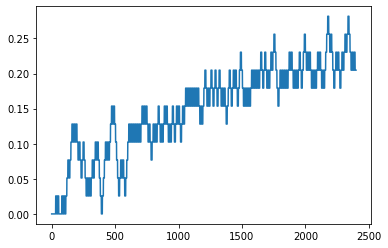

In [ ]:
plt.plot(vaegan_trainer.ada_p_log)
plt.show()